In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import datasets
import torch
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

import numpy as np

from xgboost import XGBClassifier

In [3]:
torch.random.manual_seed(0)
np.random.seed(0)

In [4]:
from matplotlib.patches import Rectangle

def plot_hypercubes(ax, hypercubes: torch.Tensor, base_prediction: torch.Tensor, colors, alpha=0.4):

    for h, bp in zip(hypercubes,base_prediction):
        low, high = h[:, 0], h[:, 1]
        side_lengths = high - low

        patch = Rectangle(low, side_lengths[0], side_lengths[1], facecolor=colors[bp], alpha=alpha)
        ax.add_patch(patch)

In [5]:
# Full dataset can be downloaded here : https://archive.ics.uci.edu/dataset/280/higgs
df = pd.read_csv('small_HIGGS.csv',header=None,usecols=[1,2,3])

In [6]:
df

,1,2,3
0,0.0,1.000000,2.000000
1,1.0,0.869293,-0.635082
2,1.0,0.907542,0.329147
3,1.0,0.798835,1.470639
4,0.0,1.344385,-0.876626
...,...,...,...
996,1.0,1.062917,-1.308094
997,1.0,0.687931,-0.765594
998,0.0,0.481497,-0.444184
999,1.0,0.564766,0.262917


In [7]:
X_train, X_test, y_train, y_test = train_test_split(df[df.columns[1:]], df[df.columns[0]], random_state=0)

scl = StandardScaler().fit(X_train)
X_train = scl.transform(X_train.to_numpy())
X_test = scl.transform(X_test.to_numpy())

y_train_svm = torch.tensor(np.where(y_train == 0,-1,1)).unsqueeze(-1).float()
y_test_svm = np.where(y_test == 0,-1,1)

In [8]:
from torch_mas.data import DataBuffer

dataset = DataBuffer(X_train,y_train_svm)

In [9]:
import time
from torch_mas.sequential.trainer import ClassifTrainer as Trainer
from torch_mas.sequential.internal_model import SVM
from torch_mas.sequential.activation_function import BaseActivation

validity = BaseActivation(
    dataset.input_dim, 
    dataset.output_dim, 
    alpha=0.5, 
)
internal_model = SVM(
    dataset.input_dim, 
    dataset.output_dim, 
    l1=0.1, 
    memory_length=10, 
)
model = Trainer(
    validity,
    internal_model,
    R=0.3,
    imprecise_th=0.5,
    bad_th=0.0015,
    n_epochs=5,
)

t = time.time()
model.fit(dataset)
tt = time.time() - t
print(f"Total training time: {tt}s")

print("Number of agents created:", model.n_agents)



Total training time: 6.3053038120269775s
Number of agents created: 449


In [10]:
y_pred = model.predict(torch.tensor(X_test).float())
print(classification_report(y_test.round(), y_pred.round(),labels=[0,1]))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       119
           1       0.50      0.50      0.50       132

   micro avg       0.50      0.26      0.34       251
   macro avg       0.25      0.25      0.25       251
weighted avg       0.26      0.26      0.26       251



/opt/homebrew/Caskroom/miniforge/base/envs/ciel/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/ciel/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/ciel/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

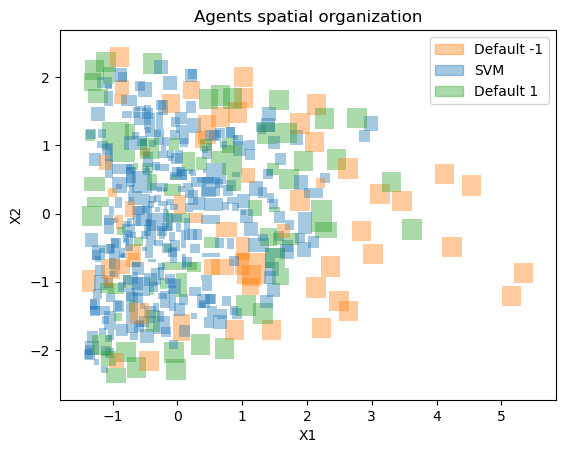

In [11]:
colors = {
    -1 : 'C1',
    0 : 'C0',
    1 : 'C2'
}

ax = plt.gca()
ax.scatter(X_train[:, 0], X_train[:, 1], marker="o", c="r", alpha=0)
plot_hypercubes(ax, model.activation.orthotopes.detach().numpy(), model.internal_model.base_prediction.numpy(),colors)
ax.set_title("Agents spatial organization")
ax.set_xlabel("X1")
ax.set_ylabel("X2")

custom_handles = [plt.Rectangle((0, 0), 1, 1, color=colors[-1], alpha=0.4),
                  plt.Rectangle((0, 0), 1, 1, color=colors[0], alpha=0.4),
                  plt.Rectangle((0, 0), 1, 1, color=colors[1], alpha=0.4)]
custom_labels = ['Default -1', 'SVM', 'Default 1']

ax.legend(handles=custom_handles, labels=custom_labels)


### XGBoost

In [12]:
bst = XGBClassifier()
bst.fit(X_train, y_train)
y_pred = bst.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.43      0.40      0.42       119
         1.0       0.49      0.52      0.51       132

    accuracy                           0.47       251
   macro avg       0.46      0.46      0.46       251
weighted avg       0.46      0.47      0.46       251



In [27]:
import time
from torch_mas.batch.trainer import ClassifTrainer as Trainer
from torch_mas.batch.internal_model import SVM
from torch_mas.batch.activation_function import BaseActivation, AVRTActivation

device='cpu'

activation = AVRTActivation(
    dataset.input_dim, 
    dataset.output_dim, 
    device=device
)

internal_model = SVM(
    dataset.input_dim,
    dataset.output_dim,
    lr=1e-2,
    memory_length=5,
    alpha=0.5,
    device=device
)

model = Trainer(
    activation,
    internal_model,
    R=0.3,
    bad_th=0.0015,
    imprecise_th=0.5,
    n_epochs=50,
    batch_size=64,
    device=device
)

t = time.time()
model.fit(dataset)
tt = time.time() - t
print(f"Total training time: {tt}s")

print("Number of agents created:", model.n_agents)

Total training time: 1.9958088397979736s
Number of agents created: 226


In [21]:
y_pred = model.predict(torch.tensor(X_test).float())
print(classification_report(y_test.round(), y_pred.round(),labels=[0,1]))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       119
           1       0.51      0.56      0.53       132

   micro avg       0.51      0.29      0.37       251
   macro avg       0.25      0.28      0.27       251
weighted avg       0.27      0.29      0.28       251



/opt/homebrew/Caskroom/miniforge/base/envs/ciel/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/ciel/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/ciel/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

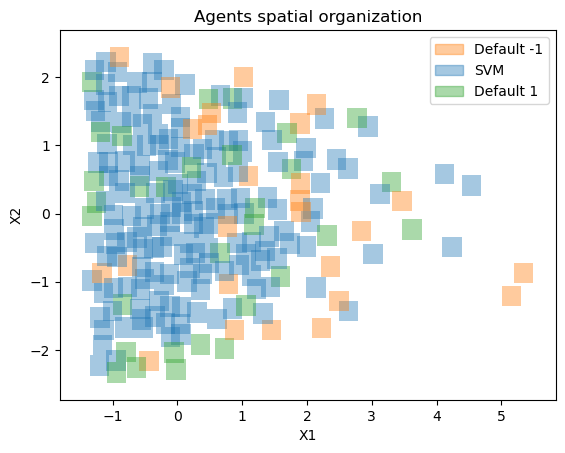

In [28]:
colors = {
    -1 : 'C1',
    0 : 'C0',
    1 : 'C2'
}

ax = plt.gca()
ax.scatter(X_train[:, 0], X_train[:, 1], marker="o", c="r", alpha=0)
plot_hypercubes(ax, model.activation.orthotopes.detach().numpy(), model.internal_model.base_prediction.numpy(),colors)
ax.set_title("Agents spatial organization")
ax.set_xlabel("X1")
ax.set_ylabel("X2")

custom_handles = [plt.Rectangle((0, 0), 1, 1, color=colors[-1], alpha=0.4),
                  plt.Rectangle((0, 0), 1, 1, color=colors[0], alpha=0.4),
                  plt.Rectangle((0, 0), 1, 1, color=colors[1], alpha=0.4)]
custom_labels = ['Default -1', 'SVM', 'Default 1']

ax.legend(handles=custom_handles, labels=custom_labels)
